In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [2]:
import tensorflow as tf
import numpy as np

from konlpy.tag import Mecab
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.2.0


# 1. 데이터 로드 및 확인

In [3]:
path_to_file_1 = os.getenv('HOME')+'/mini_projects/_G-04_seq2seq_NMT/korean-english-park.train.ko'
path_to_file_2 = os.getenv('HOME')+'/mini_projects/_G-04_seq2seq_NMT/korean-english-park.train.en'

In [4]:
with open(path_to_file_1, "r") as f:
    train_raw = f.read().splitlines()
    
print("Train Data Size:", len(train_raw))
print("Train_raw:", train_raw[0:3])

Train Data Size: 94123
Train_raw: ['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"', '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.', '그러나 이것은 또한 책상도 필요로 하지 않는다.']


In [5]:
with open(path_to_file_2, "r") as f:
    target_raw = f.read().splitlines()
    
print("Target Data Size:", len(target_raw))
print("Target_raw:", target_raw[0:3])

Target Data Size: 94123
Target_raw: ['Much of personal computing is about "can you top this?"', 'so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.', "Like all optical mice, But it also doesn't need a desk."]


# 2. 데이터 중복 확인 및 제거

In [6]:
cleaned_corpus = set(zip(train_raw,target_raw))

In [7]:
len(cleaned_corpus)

78968

In [8]:
q, r = len(set(train_raw)), len(set(target_raw))
print(q, r)

77591 75598


### 중복을 제거한 타겟셋 크기에 맞춰서 훈련셋 중복제거

In [9]:
train_dic = {}
for i, j in enumerate(train_raw):
    train_dic[i]=j
    
target_dic = {}
for i, j in enumerate(target_raw):
    target_dic[i]=j
    
target_unique_dic = {}
for i, j in target_dic.items():
    if j not in target_unique_dic.values():
        target_unique_dic[i] = j 
        
train_unique_dic = {}
for i, j in train_dic.items():
    if i in target_unique_dic.keys():
        train_unique_dic[i] = j 

print(len(train_unique_dic), len(target_unique_dic))

75598 75598


# 3. 데이터 전처리

In [10]:
cleaned_eng_corpus = {}
cleaned_kor_corpus = {}
mecab = Mecab()

def preprocess_sentence(train_unique_dic, target_unique_dic):
    
    for idx, sentence in target_unique_dic.items():
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z0-9?.!,]+", " ", sentence)
        sentence = sentence.strip()
        sentence_list = sentence.split()
        if len(sentence_list) <= 48:
            sentence = '<start> ' + sentence
            sentence += ' <end>'
            sentence = sentence.split()
            cleaned_eng_corpus[idx] = sentence
    
    for idx, sentence in train_unique_dic.items():
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)   
        sentence = re.sub(r"[^ㄱ-ㅎ가-힣0-9.,?!]+", " ", sentence)
        result = mecab.morphs(sentence)
        if len(result) <= 50:
            cleaned_kor_corpus[idx] = result
    
    return cleaned_eng_corpus, cleaned_kor_corpus

In [11]:
cleaned_eng_corpus, cleaned_kor_corpus = preprocess_sentence(train_unique_dic, target_unique_dic)

In [12]:
print(cleaned_eng_corpus[100], cleaned_kor_corpus[100])

['<start>', 'Gates', ',', 'who', 'opened', 'the', '23rd', 'annual', 'Comdex', 'trade', 'show', ',', 'said', 'there', 'was', 'a', 'negative', 'perception', 'of', 'high', 'tech', 'following', 'the', 'collapse', 'of', 'the', 'tech', 'bubble', 'about', 'two', 'years', 'ago', '.', '<end>'] ['제', '23', '차', '연례', '컴덱스', '박람회', '의', '개회사', '를', '한', '케이츠', '는', '2', '년', '여전', '기술', '산업', '의', '거품', '이', '붕괴', '된', '이후', '에', '첨단', '기술', '에', '대해', '부정', '적', '인', '인식', '이', '있', '다고', '말', '했', '다', '.']


In [13]:
print(len(cleaned_eng_corpus), len(cleaned_kor_corpus))

73415 71573


In [14]:
set_temp1 = set(cleaned_eng_corpus.keys())
set_temp2 = set(cleaned_kor_corpus.keys())
set_temp3 = set_temp2.intersection(set_temp1)
len(set_temp3)

70406

In [15]:
train_list = []
target_list = []

for i, j in cleaned_eng_corpus.items():
    if i in set_temp3:
        target_list.append(j)
        
for i, j in cleaned_kor_corpus.items():
    if i in set_temp3:
        train_list.append(j)
print(len(train_list), len(target_list))

70406 70406


In [16]:
del q
del r
del train_dic
del target_dic
del train_unique_dic
del target_unique_dic
del cleaned_eng_corpus
del cleaned_kor_corpus
del set_temp1
del set_temp2
del set_temp3

# 토크나이징

In [17]:
maxlen = 50
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=20000)
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen = maxlen)

    return tensor, tokenizer

In [18]:
enc_tensor, enc_vocab = tokenize(train_list)
dec_tensor, dec_vocab = tokenize(target_list)

print("Korean Vocab Size:", len(enc_vocab.index_word))
print("English Vocab Size:", len(dec_vocab.index_word))

Korean Vocab Size: 41750
English Vocab Size: 44129


In [19]:
print(len(enc_tensor[12400]), len(dec_tensor[12400]))

50 50


# 모델 설계

In [20]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [21]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out


In [22]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [23]:
# 코드를 실행하세요.

BATCH_SIZE     = 48
SRC_VOCAB_SIZE = len(enc_vocab.index_word) + 1 
TGT_VOCAB_SIZE = len(dec_vocab.index_word) + 1 

units         = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 50

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (48, 50, 128)
Decoder Output: (48, 44130)
Decoder Hidden State: (48, 128)
Attention: (48, 50, 1)


In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [25]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

# 모델 훈련

In [26]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 15

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_vocab)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 15: 100%|██████████| 1467/1467 [04:17<00:00,  5.70it/s, Loss 1.9181]


In [27]:
def preprocess_sentence(sentence):

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)   
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣0-9.,?!]+", " ", sentence)
    result = mecab.morphs(sentence)

    return result

In [28]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_vocab.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_vocab.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_vocab.index_word[predicted_id] + ' '

        if dec_vocab.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))



# 번역 품질 평가

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: two people were killed and wounded . <end> 


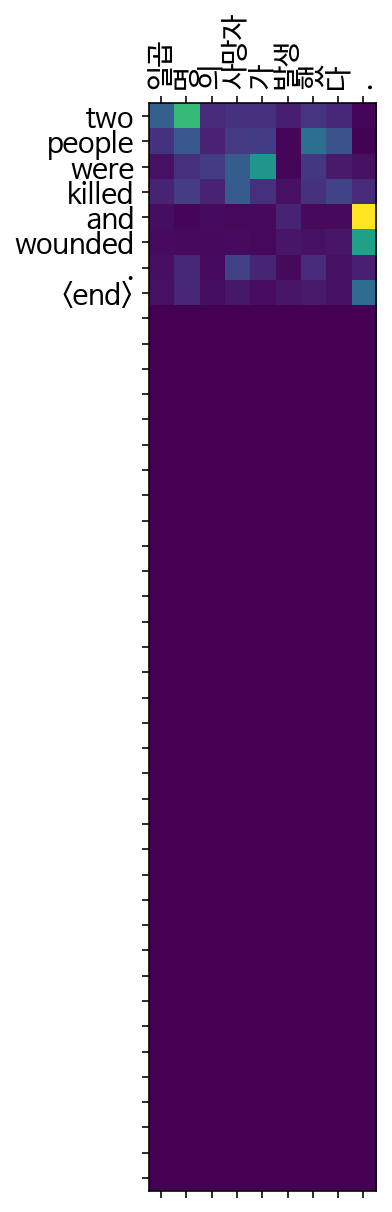

In [29]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: you re going to be able to get a lot of the size of the average of the size of the average of the size of the average of the size of the average of the size of the average of the size of the average of the size of 


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


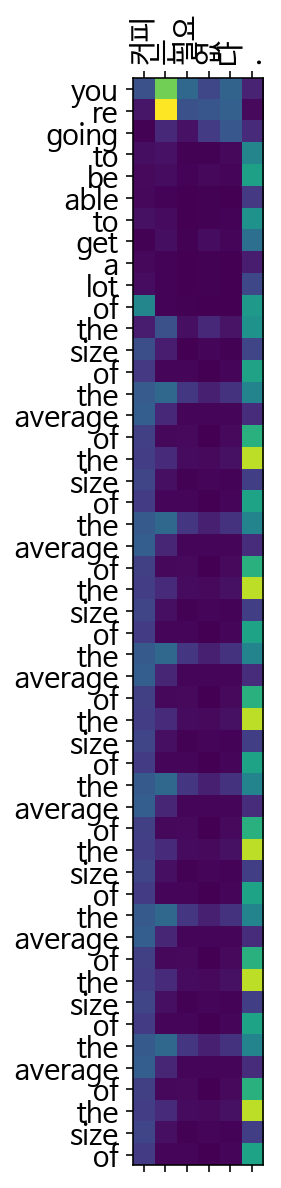

In [30]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: they are in the country . <end> 


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


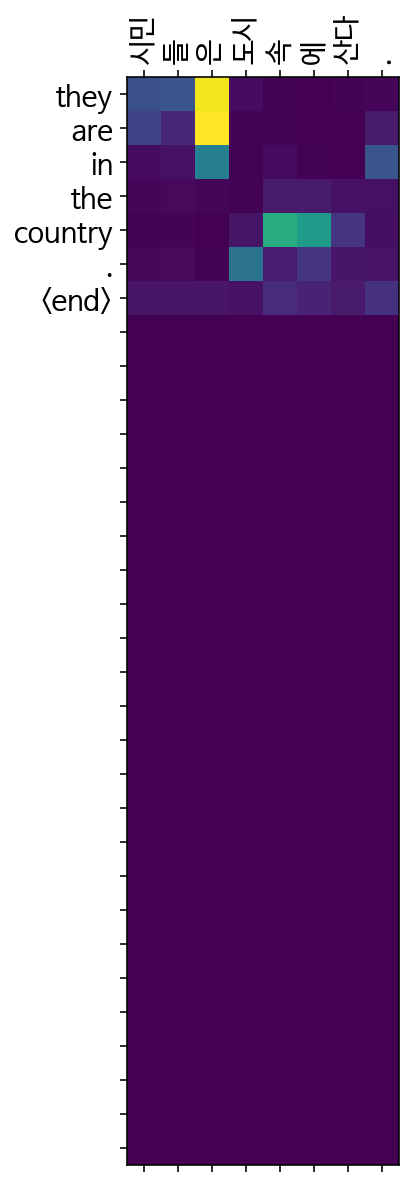

In [31]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama s a president . <end> 


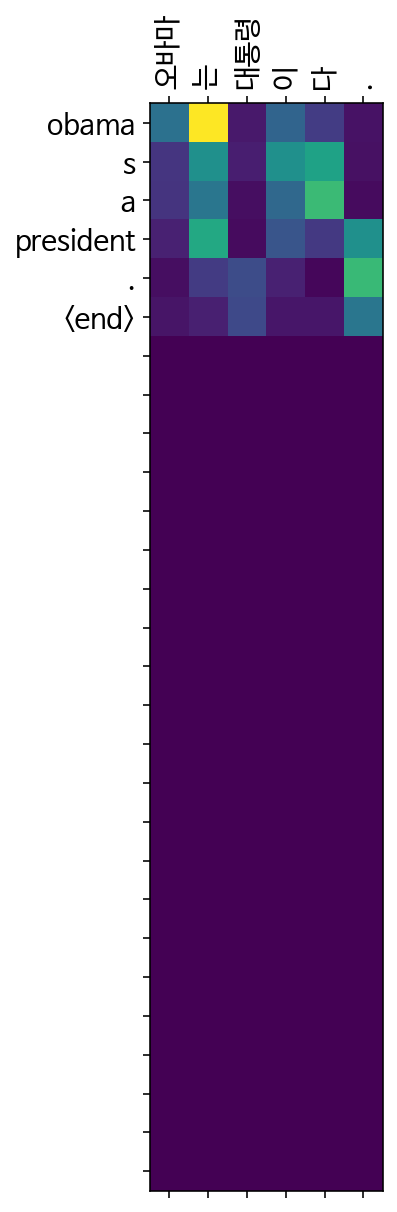

In [32]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']   
Predicted translation: two people were killed and wounded . <end>   
   
    
Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']   
Predicted translation: they are in the country . <end>    
   
    
Input: ['오바마', '는', '대통령', '이', '다', '.']   
Predicted translation: obama s a president . <end>    

## 네 문장중 3개는 그럴듯 하다.

# 회고

26시간째 붙잡고 있다.   
메모리가 수십번 터지고, 모델 이해는 여전히 오리무중인 건 둘째치고   
전처리 과정이 너무 힘들었다.   


단순히 set과 zip을 써서 하는 방법에는 문제가 있다고 생각했다.   
훈련데이터와 타겟데이터의 중복을 각각 제거 했을 때 크기가 다르기 때문에   
더 작은 데이터셋에 맞춰 총 개수를 일치시키고   
input length에 맞게 길이를 자르는 과정에서 스페셜토큰이 손실되지 않도록   
각 데이터셋을 딕셔너리로 변환해 병렬 쌍 순서를 유지하면서 데이터셋을 전처리하는 코드를 짜는 데 많은 시간을 쏟았다.      

**구체적으로 설명하면 이건 번역문제이므로 훈련샘플과 레이블 데이터의 병렬쌍이 순서대로 유지되는게 제일 중요하다고 판단했다.   
따라서 중복 제거시 어느 한쪽이 크다면 작은쪽에 맞춰야 쌍과 순서가 유지된다.   
또한 디코더에 입력되는 레이블 데이터의 스페셜 토큰도   
입력 길이를 임의로 제한한 다음 토큰화 했을 때   
훈련샘플에는 스페셜 토큰의 개수가 더 적게 들어가므로 병렬 쌍 유지가 깨지게 된다고 판단했다.   
병렬 쌍과 순서를 계속 유지하면서 토큰화를 하기 위해 코드가 너저분했지만   
나의 접근방법이 틀리진 않다고 생각한다. 하지만 피드백이 필요하다. 내 생각이 맞는지, 틀리다면 왜 틀렸는지**   
      
         
   
이렇게 오랜 시간을 들였음에도   
첫번째 시도에서 번역품질이 좋지 않았다.   
loss가 떨어지지 않았디.
하이퍼 파라미터를 이리저리 바꿔보았지만   
별 효과가 없었다.  
   
      
그럴때마다 전처리에 더 공을 들였고   
혹시나 해서 입력길이를 40에서 50으로 늘렸더니      
loss 하락폭이 소폭 상승했다.   
   
어떻게 하면 번역품질을 높일 수 있을까...   
데이터셋이 적은건 문제라고 생각하지 않는다.   
더 정교한 전처리와 고급 학습기법들을 적용할 수 있다면   
성능을 더 끌어 올릴 수 있다는 생각이 들었다.   
   
하지만 모델 설계 코드를 완전히 숙지하지 못한 상태라   
다시 전처리로 돌아갈 수밖에 없었다.      
   
한국어 데이터셋은 형태소분석기를 썼지만   
영어 데이터셋은 공백기반 토큰화를 한 게 첫 번째 한계라고 생각한다.   
서브워드 토크나이즈를 해보고 싶은데   
그러면 모델의 입력값이 달라지고 전체적인 모델의 흐름을 다 손봐야 할 것 같아   
아직 시도를 못하고 있다.   
   
그 전 단계에서 임베딩의 품질을 올릴 수 있는 방법이 뭐가 있을까?   
레이블 작업은 현재 내 수준으로 할 수 있는 한 최선을 한 것 같다.   
임베딩 자체를 다른 방법으로 해보는 게 유일한 방법 같다.   
   
한 말을 또 하고 있다.   
집중력이 거의 바닥난 상태다.   
그래.. 오리지널 데이터의 특징을 제대로 살리지 못한 전처리를 했다는 문제가 남아 있다.   
훈련샘플과 타겟데이터의 쌍을 비교해본 결과   
일대일 대응 관계를 벗어난 쌍들이 몇 개 있었다.   
전체 데이터가 수만여개 되므로 위와 같은 데이터들이 번역 품질 저하를 가져온 원인일 수 있다.   
예컨대 x번째 한국어 문장 A에 해당하는 영어 문장이 x, x+1번째 문장 A', A''에 해당하는 식이다.   
이 반대의 형태도 분명 있을 것이다.   
그렇다면 이건   
주어진 데이터셋 자체의 문제다.   
내가 아무리 전처리를 잘했다고 한들   
샘플과 레이블이 일대일로 대응하는 데이터셋이 아니라면   
거기서 성능을 더 끌어올릴 수 있는 방법은   
오리지널 데이터셋 자체를 다시 검토해서 레이블작업을 다시하는 수밖에 없다.   
   
아니면 에폭을 한 100으로 줘보는 것도 방법이 될 수 있다.   
15 에폭까지 돌렸을 때 하락세가 계속 유지됐으므로...   
   
아직 트랜스포머가 남았다.   
이 프로젝트는 여기까지 하는 걸로 하고   
내가 부족했던 부분을 다시 한 번  짚어 보자.   
   
1. 정규표현식을 더 자유자재로 쓰고 싶다. 중복처리, 불용어 제거, 특수기호 처리, 띄어쓰기, 오탈자 등 전처리를 빠르게 수행할 수 있는 코딩실력.  
2. 말뭉치의 특성에 따라 임베딩을 자유자재로 쓰고 싶다. 임베딩을 하는 건 문제가 안되는 데 그걸 모델에 입력시키는 과정이 아직 머릿속에 명확하지 않다.   
2. 모델 설계 능력. gradient tape 가 날 너무 빡치게 했다. 커스터마이징하기 좋은 툴이라는 건 알겠는데   
하... 트랜스포머 챗봇까지만 하고 다시 여기로 돌아와 첨부터 시작해야겠다.   